In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only tif
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()

2024-11-23 15:06:56.021111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732403216.069572  430763 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732403216.083976  430763 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 15:06:56.157601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from phasepack.phasecong import phasecong
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

def extract_features(image):
    """
    Extracts features required for BIQA:
    - Mean Phase Congruency (MPC)
    - Entropy of Phase Congruency (EPC)
    - Entropy of the Image (EDIS)
    - Mean Gradient Magnitude of the Image (MGDIS)
    
    Parameters:
    - image: np.array, input grayscale image

    Returns:
    - features: list of feature values [MPC, EPC, EDIS, MGDIS]
    """
    # Compute Phase Congruency
    pc_image, *_ = phasecong(image)
    mpc = np.mean(pc_image)
    epc = shannon_entropy(pc_image)

    # Compute Image Entropy
    edis = shannon_entropy(image)

    # Compute Mean Gradient Magnitude
    gradient_image = sobel(image)
    mgdis = np.mean(gradient_image)

    return [mpc, epc, edis, mgdis]

def prepare_feature_dataset(metadata):
    """
    Extract features and labels for a given dataset.
    """
    features = []
    labels = []
    for _, row in metadata.iterrows():
        image_path = row['filepath']  # Replace with the correct column name for image paths
        try:
            image = io.imread(image_path, as_gray=True)  # Load the image
            feature = extract_features(image)  # Extract features
            features.append(feature)
            labels.append(row['dose_Gy'])  # Replace 'dose' with your target column name
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    return np.array(features), np.array(labels)


def load_or_prepare_features(metadata, hr_post_exposure, particle_type):
    filtered_metadata = metadata[
        (metadata['hr_post_exposure'] == hr_post_exposure) &
        (metadata['particle_type'] == particle_type)
    ]
    processed_dir = "processed_features"

    # Define filenames dynamically based on filtering criteria
    train_path = os.path.join(processed_dir, f"train_hr{hr_post_exposure}_particle{particle_type}.pkl")
    val_path = os.path.join(processed_dir, f"val_hr{hr_post_exposure}_particle{particle_type}.pkl")
    test_path = os.path.join(processed_dir, f"test_hr{hr_post_exposure}_particle{particle_type}.pkl")

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Loading processed datasets and metadata...")
        with open(train_path, "rb") as f:
            X_train, y_train, train_metadata = pickle.load(f)
        with open(val_path, "rb") as f:
            X_val, y_val, val_metadata = pickle.load(f)
        with open(test_path, "rb") as f:
            X_test, y_test, test_metadata = pickle.load(f)
    else:
        print("Processed datasets not found. Calculating features...")

        # Shuffle and split metadata
        shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
        train_size = int(len(shuffled_metadata) * 0.7)
        val_size = int(len(shuffled_metadata) * 0.2)

        train_metadata = shuffled_metadata[:train_size]
        val_metadata = shuffled_metadata[train_size:train_size + val_size]
        test_metadata = shuffled_metadata[train_size + val_size:]

        # Extract features and labels
        X_train, y_train = prepare_feature_dataset(train_metadata)
        X_val, y_val = prepare_feature_dataset(val_metadata)
        X_test, y_test = prepare_feature_dataset(test_metadata)

        # Normalize features
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Save datasets with metadata
        os.makedirs(processed_dir, exist_ok=True)
        with open(train_path, "wb") as f:
            pickle.dump((X_train, y_train, train_metadata), f)
        with open(val_path, "wb") as f:
            pickle.dump((X_val, y_val, val_metadata), f)
        with open(test_path, "wb") as f:
            pickle.dump((X_test, y_test, test_metadata), f)

    return X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata


# Define filtering criteria
hr_post_exposure = 4
particle_type = 'X-ray'

# Pass criteria explicitly to the function
X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata = load_or_prepare_features(
    metadata, hr_post_exposure, particle_type
)

print(f"Filtering Criteria - hr_post_exposure: {hr_post_exposure}, particle_type: {particle_type}")
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Processed datasets not found. Calculating features...
Filtering Criteria - hr_post_exposure: 4, particle_type: X-ray
Train size: 9785, Validation size: 2795, Test size: 1399


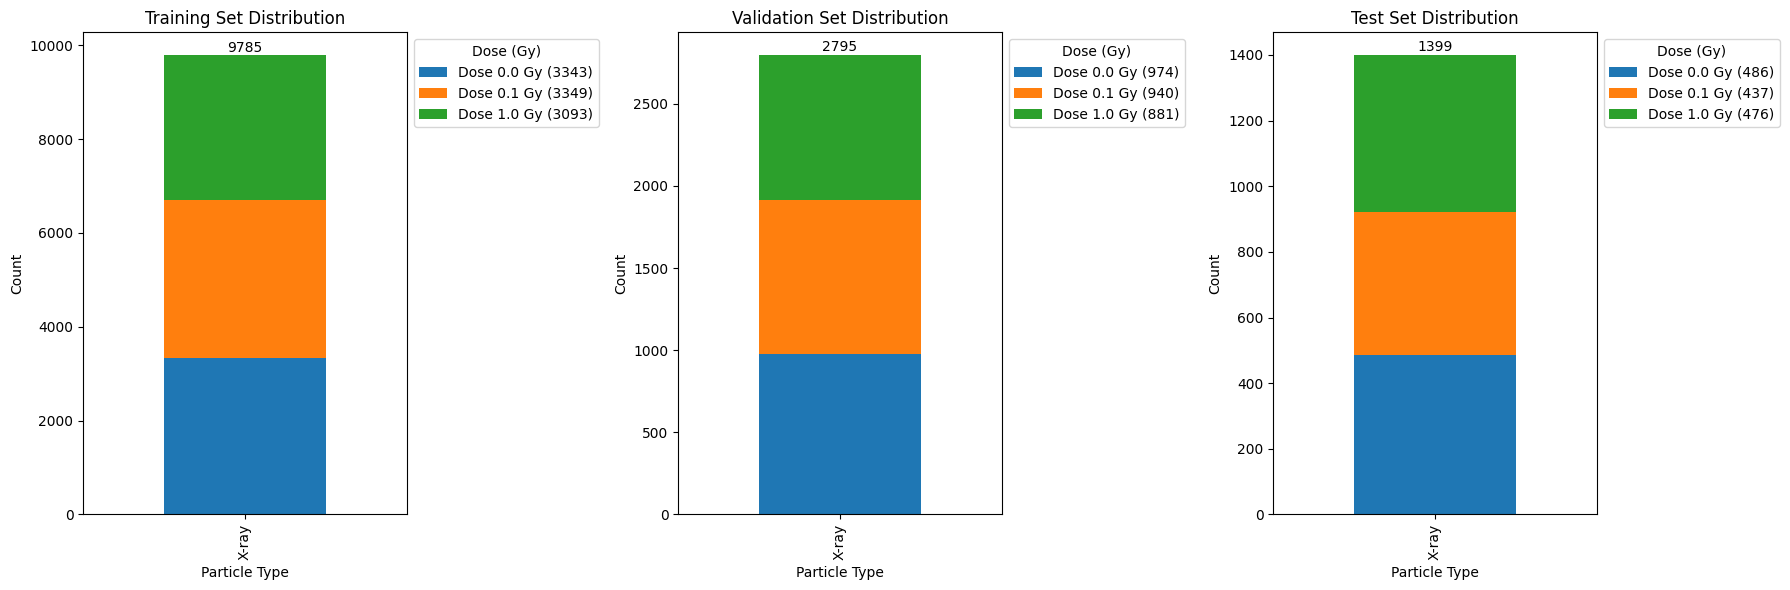

In [9]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize W&B
wandb.init(
    project="dose-prediction",
    config={
        "input_dim": 4,  # Number of extracted features
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs": 10,
        "loss_function": "mean_squared_error",
        "optimizer": "Adam",
        "architecture": "General regression neural network",
    },
    tags=["xray_4hr", "grnn", "noclip" ]
)


# Define GRNN-like network using Keras
def grnn(input_dim, sigma=0.04):
    """
    Build a GRNN-like network using Keras.

    Parameters:
    - input_dim: Number of input features
    - sigma: Spread parameter for the Gaussian activation function

    Returns:
    - Compiled Keras model
    """
    inputs = layers.Input(shape=(input_dim,))
    pattern_layer = layers.Dense(64, activation='relu')(inputs)
    summation_layer = layers.Dense(32, activation='relu')(pattern_layer)
    outputs = layers.Dense(1, activation='linear')(summation_layer)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate),
                  loss=wandb.config.loss_function,
                  metrics=['mae'])
    return model

# Build and compile the model
model = grnn(wandb.config.input_dim)


# Define callbacks
metrics_logger = WandbMetricsLogger(log_freq="epoch")
model_checkpoint = WandbModelCheckpoint(filepath="model-checkpoints/model.epoch{epoch:02d}.keras")

# Model summary
wandb.log({"Model Summary": model.summary()})

# Define the custom evaluation callback for GRNN
class DosePredictionEval(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        """
        Custom evaluation callback for GRNN.

        Parameters:
        - validation_data: Tuple of (features, labels) for validation
        - data_table_columns: List of columns for the ground truth table
        - pred_table_columns: List of columns for the prediction table
        """
        super().__init__(data_table_columns, pred_table_columns)
        self.features, self.labels = validation_data  # Validation feature vectors and labels

    def add_ground_truth(self, logs=None):
        """
        Log the ground truth data.
        """
        for idx, (feature, label) in enumerate(zip(self.features, self.labels)):
            self.data_table.add_data(idx, feature.tolist(), label)

    def add_model_predictions(self, epoch, logs=None):
        """
        Log model predictions.
        """
        preds = self.model.predict(self.features)
        for idx, (feature, label, pred) in enumerate(zip(self.features, self.labels, preds)):
            self.pred_table.add_data(
                epoch, idx, feature.tolist(), label, pred[0]
            )


# Prepare a batch for evaluation
# Use a small subset of the validation dataset for logging
val_features, val_labels = X_val[:10], y_val[:10]

# Define the evaluation callback
eval_callback = DosePredictionEval(
    validation_data=(val_features, val_labels),
    data_table_columns=["index", "features", "true dose"],
    pred_table_columns=["epoch", "index", "features", "true dose", "predicted dose"],
)



# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    callbacks=[metrics_logger, model_checkpoint],
)


# Log final evaluation metrics
test_loss, test_mae = model.evaluate(X_test, y_test)
wandb.log({"Test Loss": test_loss, "Test MAE": test_mae})


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


I0000 00:00:1732405603.002175  430763 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1732405605.653870  561223 service.cc:148] XLA service 0x7f0fcc004f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732405605.654010  561223 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-23 15:46:45.688560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732405605.766364  561223 cuda_dnn.cc:529] Loaded cuDNN version 90501


103/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2091 - mae: 0.3735

I0000 00:00:1732405606.594019  561223 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1776 - mae: 0.3561 - val_loss: 0.1390 - val_mae: 0.3106
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1376 - mae: 0.3001 - val_loss: 0.1361 - val_mae: 0.2893
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1329 - mae: 0.2912 - val_loss: 0.1362 - val_mae: 0.2755
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1279 - mae: 0.2789 - val_loss: 0.1312 - val_mae: 0.2868
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1294 - mae: 0.2824 - val_loss: 0.1291 - val_mae: 0.2820
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1269 - mae: 0.2767 - val_loss: 0.1297 - val_mae: 0.2830
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1221 - mae: 0.2672 - val_loss: 0.1253 - val_mae: 0.2802
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1218 - mae: 0.2689 - val_loss: 0.1228 - val_mae: 0.2616
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1211 

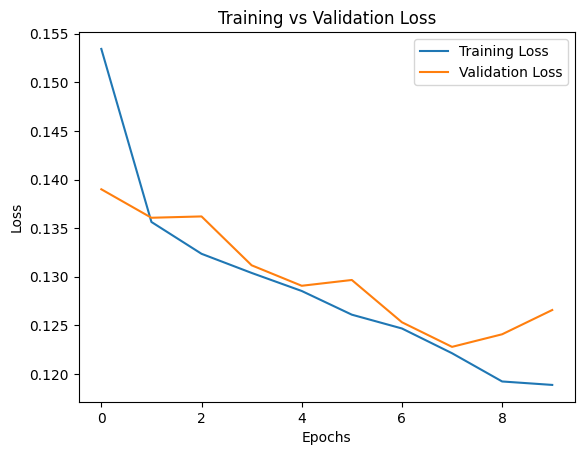

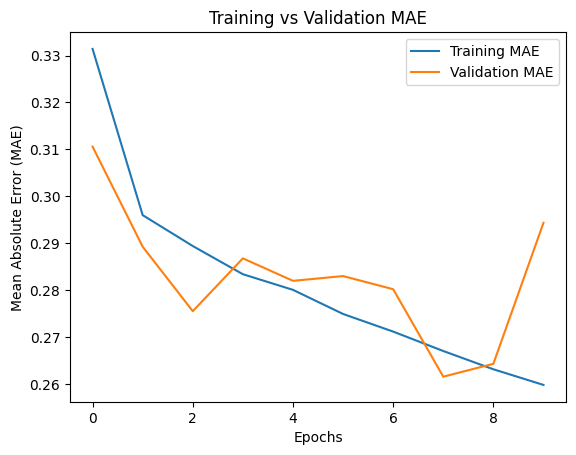

In [11]:
# Plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Save and log loss plot
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})
plt.close()

# Plot MAE curves
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training vs Validation MAE')
plt.show()

# Save and log MAE plot
plt.savefig("mae_curve.png")
wandb.log({"MAE Curve": wandb.Image("mae_curve.png")})
plt.close()


In [12]:
# Evaluate and log test metrics
from sklearn.metrics import r2_score, mean_absolute_error

true_doses = test_metadata['dose_Gy'].values
test_results = model.evaluate(X_test, y_test)

# Predict using the model
predicted_doses = model.predict(X_test).flatten()

# Log metrics to W&B
wandb.log({
    "Test Loss": test_results[0],
    "Test MAE": test_results[1],
    "R²": r2_score(true_doses, predicted_doses)
})

# Create a comparison metric (absolute error)
absolute_errors = abs(true_doses - predicted_doses)

# Create a comparison table
comparison_table = pd.DataFrame({
    "Filename": test_metadata["filepath"].values,
    "Actual Dose": true_doses,
    "Predicted Dose": predicted_doses,
    "Absolute Error": absolute_errors
})

# Log sorted comparison table to W&B
sorted_comparison_table = comparison_table.sort_values(by="Absolute Error", ascending=True).reset_index(drop=True)
wandb_table = wandb.Table(dataframe=sorted_comparison_table)
wandb.log({"Comparison Table": wandb_table})

# Log best and worst examples
best_examples = sorted_comparison_table.head(5)
worst_examples = sorted_comparison_table.tail(5)

for _, row in best_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Best Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

for _, row in worst_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Worst Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

# Print overall MAE
overall_mae = mean_absolute_error(true_doses, predicted_doses)
print(f"Overall MAE: {overall_mae}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1277 - mae: 0.2972
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall MAE: 0.29211392722400786


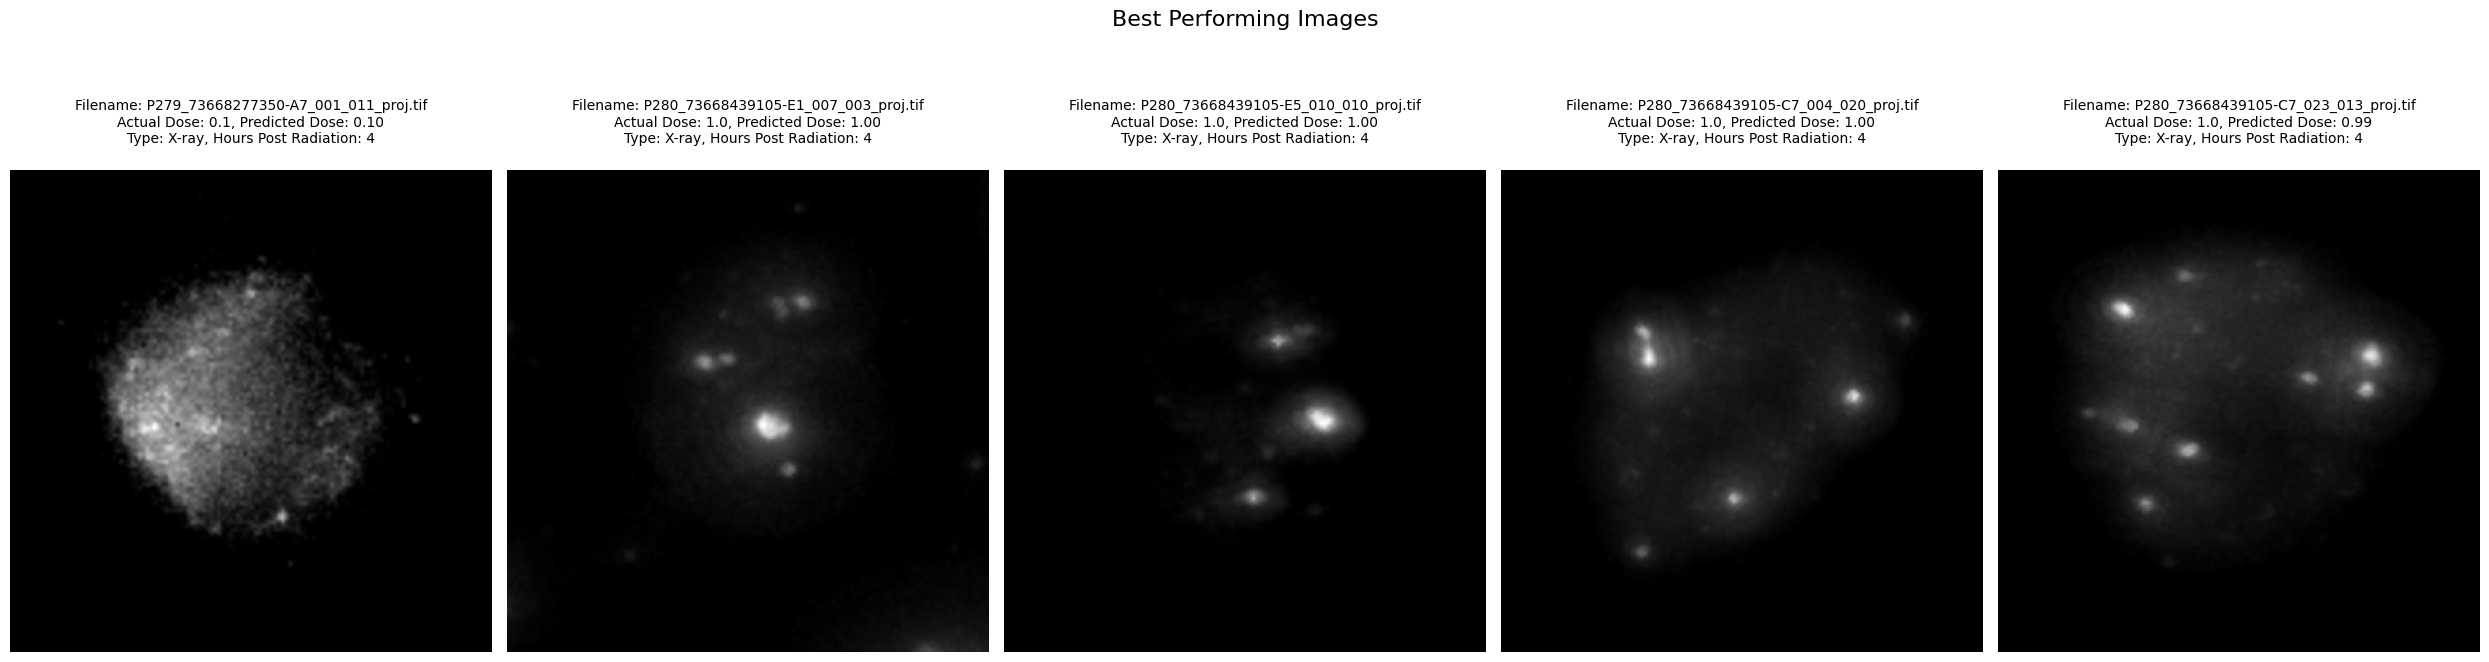

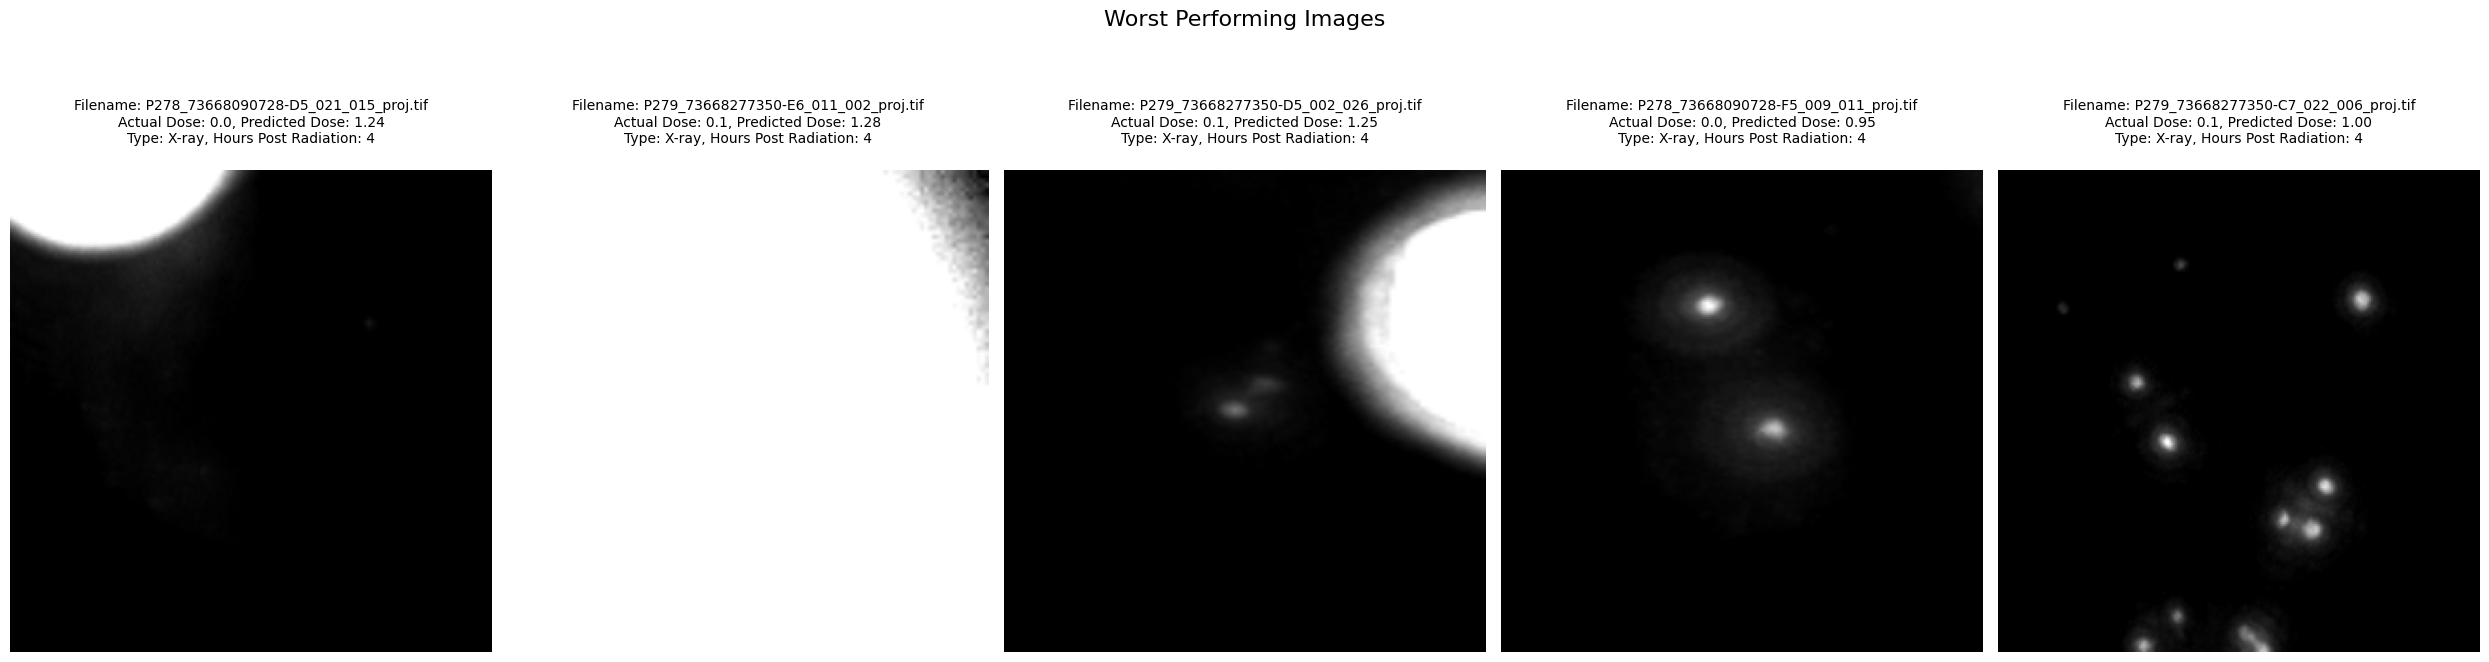

In [13]:
# Sort the data for best and worst performing images
best_performing = comparison_table.sort_values(by="Absolute Error", ascending=True).head(5)
worst_performing = comparison_table.sort_values(by="Absolute Error", ascending=False).head(5)

# Function to preprocess images (clip and normalize)
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Clip image values to [400, 4000]
    image = np.clip(image, 400, 4000)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize to [0, 1]
    image = (image - 400) / (4000 - 400)
    
    return image

# Function to load and display images with captions
def plot_images(data, title, metadata):
    fig, axes = plt.subplots(1, len(data), figsize=(25, 8))  # Increase figure width and height
    fig.suptitle(title, fontsize=16)

    for idx, (filename, actual, predicted, error) in enumerate(zip(data["Filename"], 
                                                                  data["Actual Dose"], 
                                                                  data["Predicted Dose"], 
                                                                  data["Absolute Error"])):
        # Preprocess image
        image = preprocess_image(filename)
        
        # Plot image
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        
        # Fetch metadata for captions
        metadata_row = metadata[metadata["filepath"] == filename].iloc[0]
        caption = (
            f"Filename: {filename.split('/')[-1]}\n"
            f"Actual Dose: {actual}, Predicted Dose: {predicted:.2f}\n"
            f"Type: {metadata_row['particle_type']}, Hours Post Radiation: {metadata_row['hr_post_exposure']}"
        )
        axes[idx].set_title(caption, fontsize=10, pad=20)  # Add padding to separate the title from the plot

    plt.tight_layout()
    plt.show()


# Plot best-performing images
plot_images(best_performing, "Best Performing Images", test_metadata)

# Plot worst-performing images
plot_images(worst_performing, "Worst Performing Images", test_metadata)


In [14]:
mae_per_dose = {}
for dose in [0.0, 0.1, 1.0]:
    subset = comparison_table[comparison_table['Actual Dose'] == dose]
    mae = subset['Absolute Error'].mean()
    print(f"MAE for Dose {dose}: {mae}")
    mae_per_dose[f"MAE for Dose {dose}"] = mae

# Log all MAE values together
wandb.log(mae_per_dose)


MAE for Dose 0.0: 0.2798523075050778
MAE for Dose 0.1: 0.2769823393539378
MAE for Dose 1.0: 0.31852495891018573


In [15]:
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_table, x='Actual Dose', y='Absolute Error')
plt.title("Absolute Error Distribution by Dose")
plt.xlabel("Actual Dose")
plt.ylabel("Absolute Error")

# Save the plot as an image
plt.savefig("absolute_error_boxplot.png")

# Log the plot to W&B
wandb.log({"Absolute Error Boxplot": wandb.Image("absolute_error_boxplot.png")})

# Close the plot to free memory
plt.close()

# Finish the W&B run
wandb.finish()


MAE for Dose 0.0,▁
MAE for Dose 0.1,▁
MAE for Dose 1.0,▁
R²,▁
Test Loss,▁▁
Test MAE,▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▂▂▂▁▁
epoch/mae,█▅▄▃▃▂▂▂▁▁
epoch/val_loss,█▇▇▅▄▄▂▁▂▃
